# Time Series & Forecasting

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, date
from statsmodels.tsa.statespace.tools import diff 
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

import warnings 
warnings.filterwarnings('ignore')

## Exercise 1: 

`data/babies.zip` contains baby name frequencies per year (one file per year). You can treat each baby name as its own time series 

1. Combine all of the files within the `babies.zip` file into one **DataFrame**
2. Get the autocorrelation and partial autocorrelation for the names `Olivia`, `Newton` and `John` (*difference* as needed)
3. Pick any **3** names of your choice and using **3** different ARIMA models, forecast the frequencies for each these names for the next **2** years. Provide brief interpretations of your results
**NOTE:** You are expected to use visualizations/data exploration, split your data into training & testing sets, evaluate your model, and then predict into the unknown

In [2]:
# exercise 1
dirpath = r'../data/babies'
files = [f for f in os.listdir(dirpath) if os.path.isfile(os.path.join(dirpath, f))]#get list of directories in file(babies)
babies = pd.DataFrame()#to make dataframe
year = []
for file in files[1:]:#each directory got from listdir
    df = []
    yr = file.split('.')[0][3:]
    year.append(yr)
#     print(year)
    with open(file, 'r') as file:#open file to read each line
        f = file.readlines()
    for words in f:#to clean and make datframe to be concatinated eith babies
        words = words +',' + yr
        w = words.split(',')
        df.append(w)
#         df.append(year)
    df = pd.DataFrame(df, columns=['name', 'sex', 'n_names', 'year'])
    df['n_names'] = [int(x.strip('\n')) for x in df['n_names']]#remove'\n' from items
    df.year = pd.to_datetime(df.year)#make datetime type
    babies = pd.concat([babies, df], axis=0)

In [3]:
babies.shape

(1891894, 4)

In [4]:
babies = babies[['name', 'n_names', 'year']].groupby(['name', 'year']).sum()

In [5]:
babies.index.freq = 'BAS'

In [6]:
# babies.set_index('year',inplace = True)


In [7]:
# Two functions to help better interpret ADF and KPSS results (via Statsmodels Documentation) 

from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    print('\n')
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    print('\n')
    
    if dfoutput['p-value'] < 0.05:
        print('Strong evidence against the null hypothesis')
        print('We reject the null hypothesis')
        print('Series has no unit root & is stationary')
    else:
        print('Weak evidence against the null hypothesis')
        print('We fail to reject the null hypothesis')
        print('Series has unit root and is non-stationary')
        
##############################################################
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    print('\n')
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    print('\n')
    
    if kpss_output['p-value'] < 0.05:
        print('Strong evidence against the null hypothesis')
        print('We reject the null hypothesis')
        print('Series has unit root and is non-stationary')
    else:        
        print('Weak evidence against the null hypothesis')
        print('We fail to reject the null hypothesis')
        print('Series has no unit root & is stationary')

Text(0.5, 1.0, 'name frequency of Olivia')

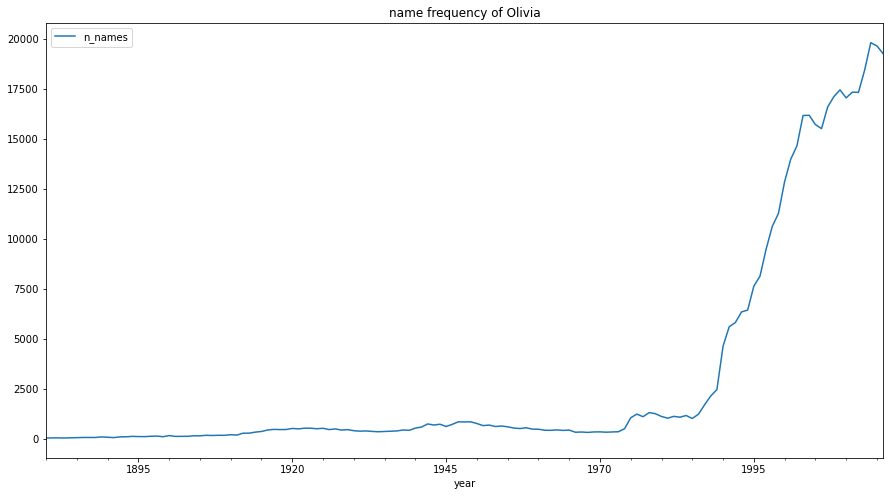

In [8]:
babies.loc['Olivia'].plot(figsize=(15, 8))#it seems there is no tren on data but in test done below denoting trend !!
plt.title('name frequency of Olivia')

In [9]:
#above shows apparently there is no stationary series but with the test done below it is clear that there is trend.

In [10]:
# babies Dataset - Trend & Seasonality

print(adf_test(babies.n_names.loc['Olivia']))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(kpss_test(babies.n_names.loc['Olivia']))

Results of Dickey-Fuller Test:


Test Statistic                  -0.333287
p-value                          0.920656
#Lags Used                      10.000000
Number of Observations Used    126.000000
Critical Value (1%)             -3.483346
Critical Value (5%)             -2.884766
Critical Value (10%)            -2.579156
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has unit root and is non-stationary
None
~~~~~~~~~~~~~~~~~~~~~~~~~~
Results of KPSS Test:


Test Statistic           1.140299
p-value                  0.010000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has unit root and is non-stationary
None


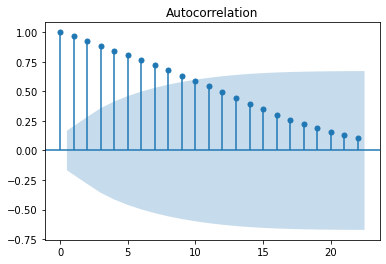

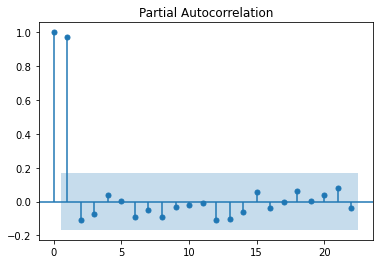

In [11]:
plot_acf(babies.n_names.loc['Olivia']);
plot_pacf(babies.n_names.loc['Olivia']);

In [12]:
#denoting correlation between names to previous year. it should be remove from the dataset

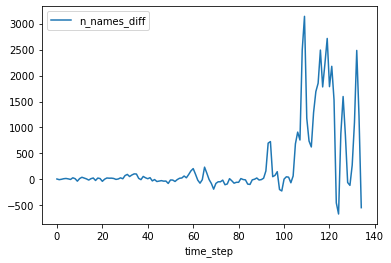

In [180]:
#to remove trend and seasonality from data. 
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.DataFrame(diff, columns = ["n_names_diff"])
n_names_diff = difference(babies.n_names.loc['Olivia'], 2)#with othe lagged step the trend has not removed just with 2.
n_names_diff['time_step'] = range(0,len(n_names_diff['n_names_diff']))
n_names_diff.plot(kind='line',x='time_step',y='n_names_diff')
plt.show()
#after correction, plot showsthe stationarity on data.

# diff(babies.n_names.loc['Olivia'], k_diff=2).plot()

Text(0.5, 1.0, 'name frequency of Newton')

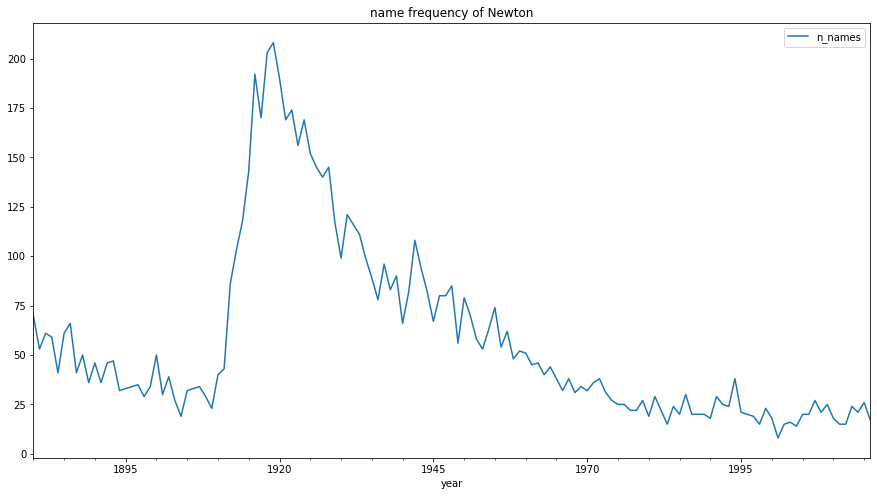

In [14]:
babies.loc['Newton'].plot(figsize=(15, 8))
plt.title('name frequency of Newton')#there is slight trend on data

In [15]:
# babies Dataset - Trend & Seasonality test

print(adf_test(babies.n_names.loc['Newton']))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(kpss_test(babies.n_names.loc['Newton']))

Results of Dickey-Fuller Test:


Test Statistic                  -1.956684
p-value                          0.305882
#Lags Used                       4.000000
Number of Observations Used    132.000000
Critical Value (1%)             -3.480888
Critical Value (5%)             -2.883697
Critical Value (10%)            -2.578586
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has unit root and is non-stationary
None
~~~~~~~~~~~~~~~~~~~~~~~~~~
Results of KPSS Test:


Test Statistic           0.674778
p-value                  0.015838
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has unit root and is non-stationary
None


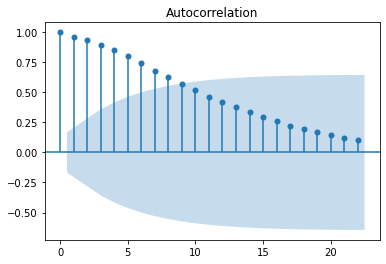

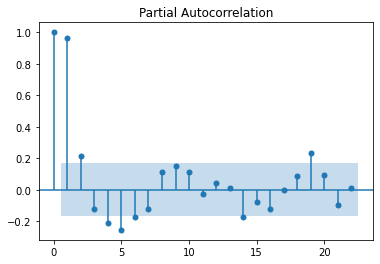

In [16]:

plot_acf(babies.n_names.loc['Newton']);
plot_pacf(babies.n_names.loc['Newton']);

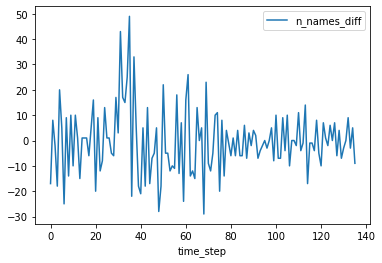

In [181]:
#to remove trend and seasonality
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.DataFrame(diff, columns = ["n_names_diff"])
n_names_diff = difference(babies.n_names.loc['Newton'], 1)
n_names_diff['time_step'] = range(0,len(n_names_diff['n_names_diff']))
n_names_diff.plot(kind='line',x='time_step',y='n_names_diff')
plt.show()
# diff(babies.n_names.loc['Newton'], k_diff=2).plot()

Text(0.5, 1.0, 'name frequency of John')

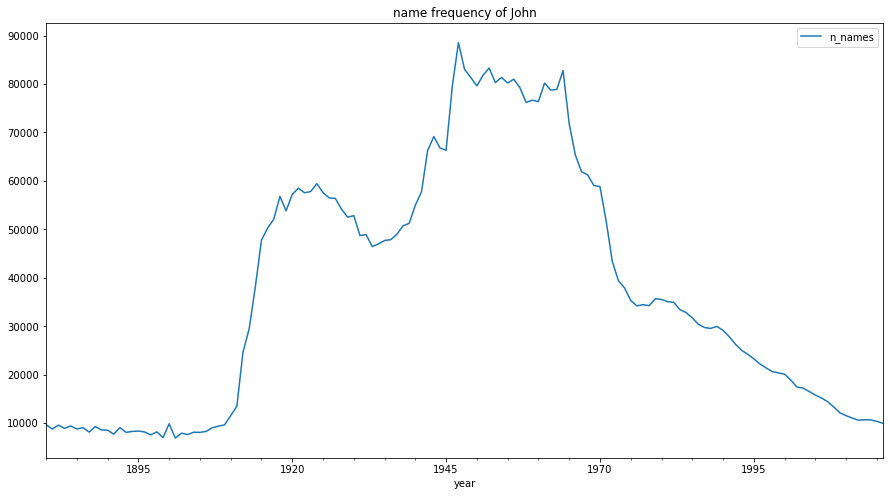

In [18]:
babies.loc['John'].plot(figsize=(15, 8))
plt.title('name frequency of John')

In [19]:
# babies Dataset - Trend & Seasonality

print(adf_test(babies.n_names.loc['John']))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(kpss_test(babies.n_names.loc['John']))

Results of Dickey-Fuller Test:


Test Statistic                  -1.796373
p-value                          0.382264
#Lags Used                       5.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has unit root and is non-stationary
None
~~~~~~~~~~~~~~~~~~~~~~~~~~
Results of KPSS Test:


Test Statistic           0.482847
p-value                  0.045530
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has unit root and is non-stationary
None


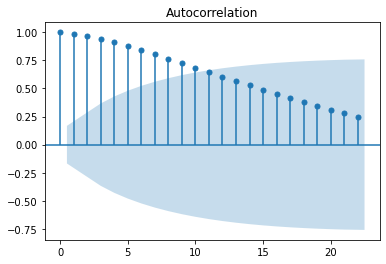

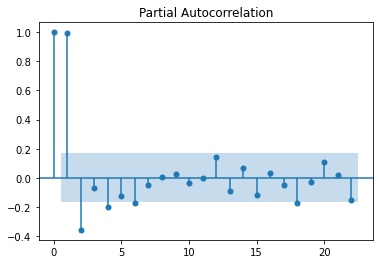

In [20]:
plot_acf(babies.n_names.loc['John']);
plot_pacf(babies.n_names.loc['John']);

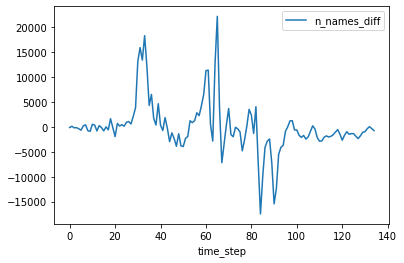

In [182]:
#to remove trend and seasonality
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
        df = pd.DataFrame(diff, columns = ["n_names_diff"])
    return df
n_names_diff = difference(babies.n_names.loc['John'], 2)#with othe lagged step the trend has not removed just with 2.
n_names_diff['time_step'] = range(0,len(n_names_diff['n_names_diff']))
n_names_diff.plot(kind='line',x='time_step',y='n_names_diff')
plt.show()

# diff(babies.n_names.loc['John'], k_diff=2).plot()  


In [22]:

print(adf_test(df.n_names))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(kpss_test(df.n_names))

Results of Dickey-Fuller Test:


Test Statistic                -1.601737e+01
p-value                        6.259184e-29
#Lags Used                     2.000000e+01
Number of Observations Used    3.284700e+04
Critical Value (1%)           -3.430549e+00
Critical Value (5%)           -2.861628e+00
Critical Value (10%)          -2.566817e+00
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has no unit root & is stationary
None
~~~~~~~~~~~~~~~~~~~~~~~~~~
Results of KPSS Test:


Test Statistic             0.599671
p-value                    0.022666
Lags Used                107.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has unit root and is non-stationary
None


In [23]:
#it would be clear as well they are stationary plots which is good for analyzing

In [24]:
mary = pd.DataFrame(babies.n_names.loc['Mary'])
emma = pd.DataFrame(babies.n_names.loc['Emma'])
anna = pd.DataFrame(babies.n_names.loc['Anna'])
name = [mary, emma, anna ]

# plotting

<AxesSubplot:xlabel='year'>

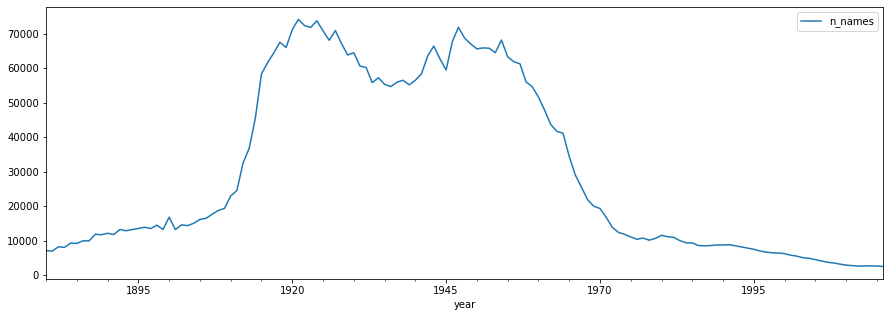

In [25]:
mary[['n_names']].plot(figsize=(15, 5))

<AxesSubplot:xlabel='year'>

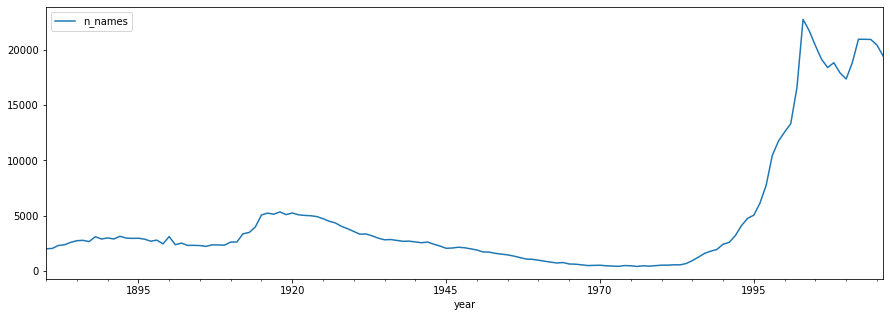

In [26]:
emma[['n_names']].plot(figsize=(15, 5))

<AxesSubplot:xlabel='year'>

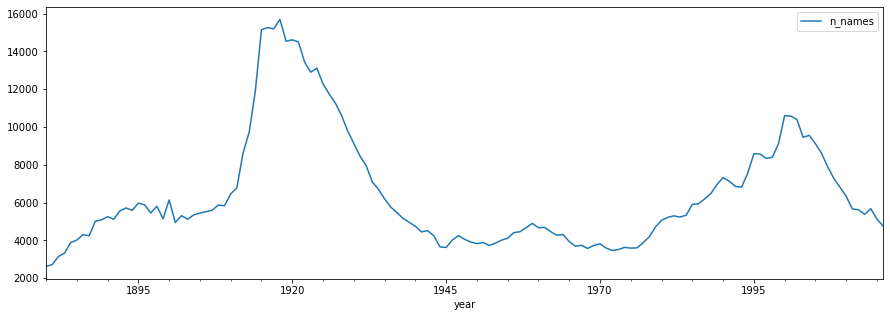

In [27]:
anna[['n_names']].plot(figsize=(15, 5))

# babies Dataset - Trend & Seasonality test

In [28]:
print(adf_test(mary[['n_names']]))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(kpss_test(mary[['n_names']]))

Results of Dickey-Fuller Test:


Test Statistic                  -1.949696
p-value                          0.309055
#Lags Used                       5.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has unit root and is non-stationary
None
~~~~~~~~~~~~~~~~~~~~~~~~~~
Results of KPSS Test:


Test Statistic           0.588399
p-value                  0.023691
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has unit root and is non-stationary
None


In [29]:
print(adf_test(emma[['n_names']]))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(kpss_test(emma[['n_names']]))

Results of Dickey-Fuller Test:


Test Statistic                  -2.584094
p-value                          0.096329
#Lags Used                      12.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has unit root and is non-stationary
None
~~~~~~~~~~~~~~~~~~~~~~~~~~
Results of KPSS Test:


Test Statistic           0.680023
p-value                  0.015362
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has unit root and is non-stationary
None


In [30]:
print(adf_test(anna[['n_names']]))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~')  #anna in comparison with other 3 names has more stationary series
print(kpss_test(anna[['n_names']]))

Results of Dickey-Fuller Test:


Test Statistic                  -2.614883
p-value                          0.089960
#Lags Used                       3.000000
Number of Observations Used    133.000000
Critical Value (1%)             -3.480500
Critical Value (5%)             -2.883528
Critical Value (10%)            -2.578496
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has unit root and is non-stationary
None
~~~~~~~~~~~~~~~~~~~~~~~~~~
Results of KPSS Test:


Test Statistic           0.169691
p-value                  0.100000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has no unit root & is stationary
None


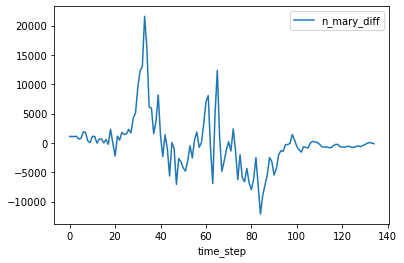

Results of Dickey-Fuller Test:


Test Statistic                -1.601737e+01
p-value                        6.259184e-29
#Lags Used                     2.000000e+01
Number of Observations Used    3.284700e+04
Critical Value (1%)           -3.430549e+00
Critical Value (5%)           -2.861628e+00
Critical Value (10%)          -2.566817e+00
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has no unit root & is stationary
None
~~~~~~~~~~~~~~~~~~~~~~~~~~
Results of KPSS Test:


Test Statistic             0.599671
p-value                    0.022666
Lags Used                107.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has unit root and is non-stationary
None


In [31]:
#to remove trend and seasonality
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.DataFrame(diff, columns = ["n_mary_diff"])
n_mary_diff = difference(mary['n_names'], 2)#with othe lagged step the trend has not removed just with 2.
n_mary_diff['time_step'] = range(0,len(n_mary_diff['n_mary_diff']))
n_mary_diff.plot(kind='line',x='time_step',y='n_mary_diff')
plt.show()
# mary_diff = diff(mary[['n_names']], k_diff=2)
# mary_diff.plot()



print(adf_test(df['n_names']))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(kpss_test(df['n_names']))

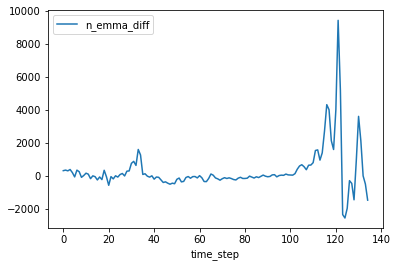

Results of Dickey-Fuller Test:


Test Statistic                -1.601737e+01
p-value                        6.259184e-29
#Lags Used                     2.000000e+01
Number of Observations Used    3.284700e+04
Critical Value (1%)           -3.430549e+00
Critical Value (5%)           -2.861628e+00
Critical Value (10%)          -2.566817e+00
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has no unit root & is stationary
None
~~~~~~~~~~~~~~~~~~~~~~~~~~
Results of KPSS Test:


Test Statistic             0.599671
p-value                    0.022666
Lags Used                107.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has unit root and is non-stationary
None


In [32]:
#to remove trend and seasonality
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.DataFrame(diff, columns = ["n_emma_diff"])
n_emma_diff = difference(emma['n_names'], 2)#with othe lagged step the trend has not removed just with 2.
n_emma_diff['time_step'] = range(0,len(n_emma_diff['n_emma_diff']))
n_emma_diff.plot(kind='line',x='time_step',y='n_emma_diff')
plt.show()
# emma_diff = diff(emma[['n_names']], k_diff=2)
# emma_diff.plot()

print(adf_test(df['n_names']))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(kpss_test(df['n_names']))

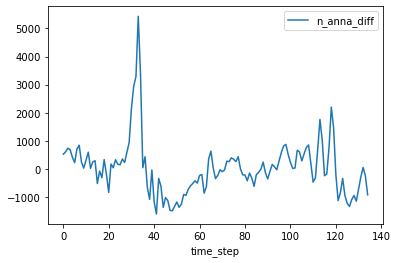

Results of Dickey-Fuller Test:


Test Statistic                -1.601737e+01
p-value                        6.259184e-29
#Lags Used                     2.000000e+01
Number of Observations Used    3.284700e+04
Critical Value (1%)           -3.430549e+00
Critical Value (5%)           -2.861628e+00
Critical Value (10%)          -2.566817e+00
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has no unit root & is stationary
None
~~~~~~~~~~~~~~~~~~~~~~~~~~
Results of KPSS Test:


Test Statistic             0.599671
p-value                    0.022666
Lags Used                107.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has unit root and is non-stationary
None


In [33]:
#to remove trend and seasonality
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
        df = pd.DataFrame(diff, columns = ["n_anna_diff"])
    return df
n_anna_diff = difference(anna['n_names'], 2)#with other lagged step the trend has not removed just with 2.
n_anna_diff['time_step'] = range(0,len(n_anna_diff['n_anna_diff']))
n_anna_diff.plot(kind='line',x='time_step',y='n_anna_diff')
plt.show()
# anna_diff = diff(anna[['n_names']], k_diff=2)
# anna_diff.plot()

#now we can see the pvalue is too lower than 0.05
print(adf_test(df['n_names']))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(kpss_test(df['n_names']))

In [34]:
#for all names in list d is 2

# p, q, d calculation: differencing, autoarima

p, q by autocorrelation and partial autocorrelation

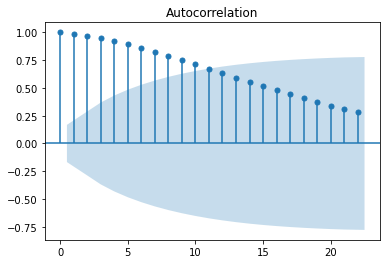

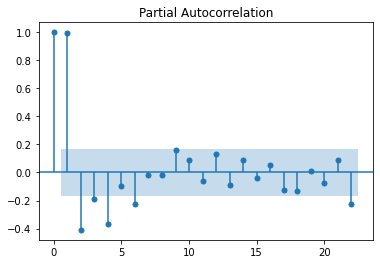

In [35]:
plot_acf(mary[['n_names']]);#q=1, p=0
plot_pacf(mary[['n_names']]);

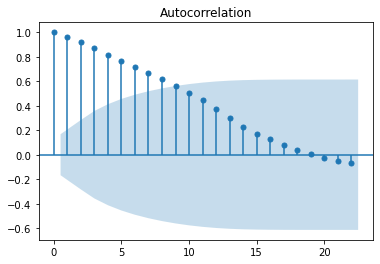

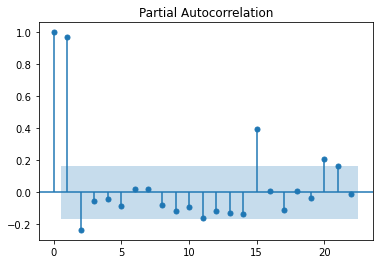

In [36]:
plot_acf(emma[['n_names']]);#q=1, p=0
plot_pacf(emma[['n_names']]);

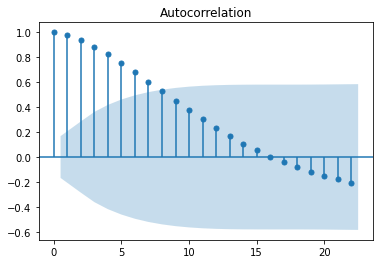

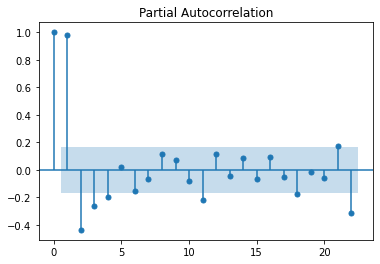

In [37]:
plot_acf(anna[['n_names']]);#q=1, p=0
plot_pacf(anna[['n_names']]);

In [38]:
#it seems auto correlation plot could not the approprate way to have p and q, bc the result from arima is ocmpletly different from.
#so it is better to use SARIMAX and seasonal_decompose to achieve better result in terms of accurate prediction

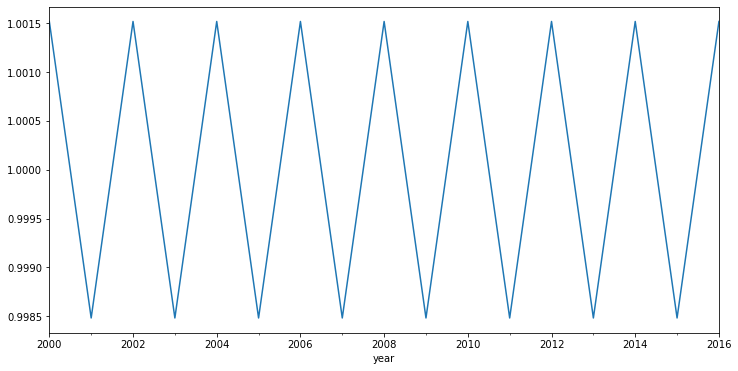

In [39]:
#zoom in on the seasonal plot and specify a time period

seasonal_decompose(mary[['n_names']].loc['2000':'2020'],model='mul', freq=2).seasonal.plot(figsize=(12,6));

#period parametr would be roughly 1


In [40]:
auto_arima(mary[['n_names']], seasonal=False, trace=True, m=12)#we can see there is no accurate interpret on autocorrelation

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=2486.401, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2540.402, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2512.940, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2484.815, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2538.417, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2486.681, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=2486.589, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=2487.934, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2482.851, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2484.718, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2484.627, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2510.945, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2485.964, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.574 seconds


ARIMA(order=(0, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

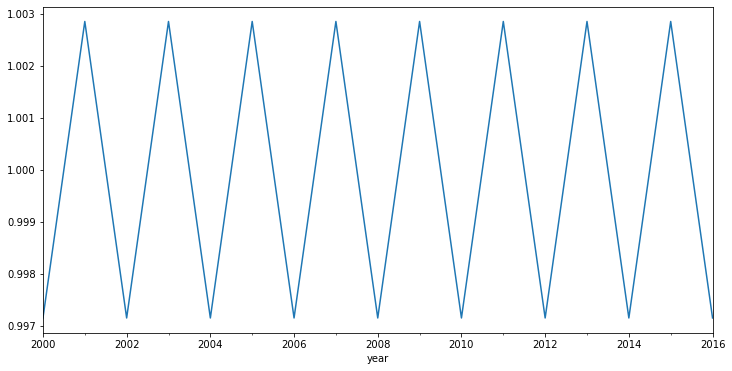

In [41]:
#  zoom in on the seasonal plot and specify a time period

seasonal_decompose(emma[['n_names']].loc['2000':'2020'],model='mul', freq=2).seasonal.plot(figsize=(12,6));

#period parametr would be clearly 1

In [42]:
auto_arima(emma[['n_names']], seasonal=False, trace=True, m=1)#.summary()#we can see there is no accurate interpret on autocorrelation

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2178.303, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2199.716, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2176.011, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2174.599, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2201.380, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2175.925, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2175.950, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2177.594, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2174.418, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2175.397, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2175.569, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2175.250, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2175.001, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.908 seconds


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

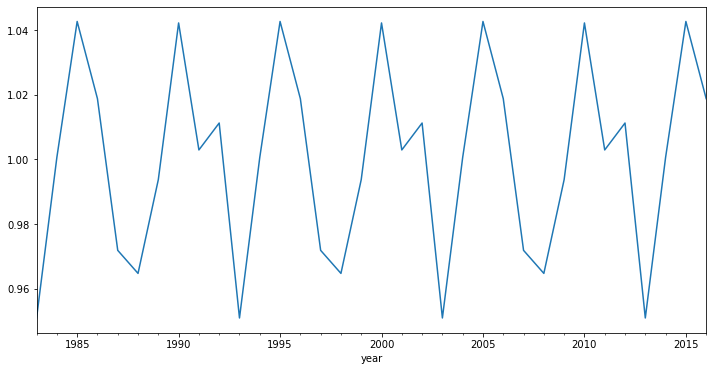

In [43]:
# Let's zoom in on the seasonal plot and specify a time period

seasonal_decompose(anna.loc['1983':'2020'],model='mul', freq=10).seasonal.plot(figsize=(12,6));

#period parametr would be roughly 1

In [44]:
auto_arima(anna[['n_names']], seasonal=False, trace=True, m=12)#.summary()#we can see there is no accurate interpret on autocorrelation

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2103.537, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2822.802, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2111.566, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2102.678, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2122.665, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2112.088, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2103.524, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2102.778, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2105.654, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2097.069, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2122.077, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2110.755, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2

ARIMA(order=(2, 0, 1), scoring_args={}, suppress_warnings=True)

# modelling and foracsting

In [45]:
mary[['n_names']].shape

(137, 1)

In [72]:
train_mary = mary.iloc[:120]
test_mary = mary.iloc[120:]
start = len(train_mary)
end = len(mary)-1
train_mary['1983']


,n_names
year,
1983-01-01,9953


In [73]:
#the series is not stationary so it is better to use SARIMAX to do forecast
models = SARIMAX(train_mary, order=(0,2,1), seasonal_order=(0,0,0,0)) .fit(disp=0)
models.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                n_names   No. Observations:                  120
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1091.301
Date:                Wed, 27 Jul 2022   AIC                           2186.602
Time:                        09:03:01   BIC                           2192.143
Sample:                    01-01-1880   HQIC                          2188.852
                         - 01-01-1999                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7033      0.048    -14.629      0.000      -0.798      -0.609
sigma2      6.755e+06      7e+05      9.647      0.000    5.38e+06    8.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                14.55
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='year'>

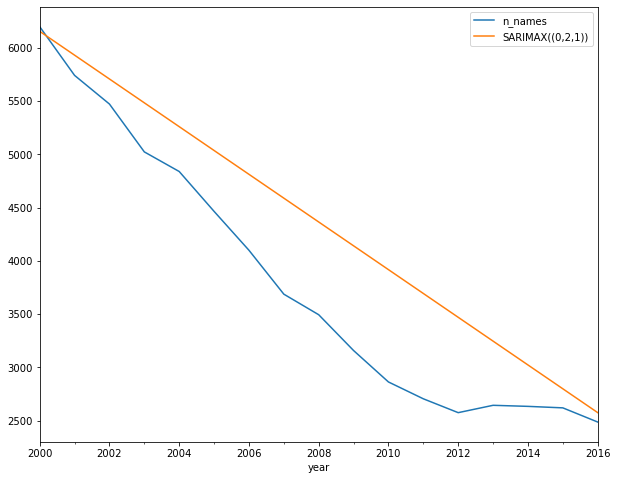

In [74]:
predictions = models.predict(start=start, end=end, typ='levels').rename('SARIMAX((0,2,1))')

test_mary.plot(legend=True, figsize=(10, 8))
predictions.plot(legend=True)


In [75]:
print('RMSE:', {rmse(test_mary.n_names, predictions)})
print('test_mean:', test_mary.n_names.mean())
print('pred_mean:', predictions.mean())
#because of the high dofference between the MSE and mean value, 
#it could be concluded that the modeling has been accurate in prediction.

RMSE: {655.0273811332162}
test_mean: 3805.764705882353
pred_mean: 4364.357194668389


In [76]:
models_a = SARIMAX(mary, order=((0,2,1)), seasonal_order=(0,0,0,0)) .fit(disp=0)
models_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                n_names   No. Observations:                  137
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1239.426
Date:                Wed, 27 Jul 2022   AIC                           2482.851
Time:                        09:03:12   BIC                           2488.662
Sample:                    01-01-1880   HQIC                          2485.213
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7036      0.042    -16.825      0.000      -0.786      -0.622
sigma2       5.88e+06   5.22e+05     11.269      0.000    4.86e+06     6.9e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                31.49
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

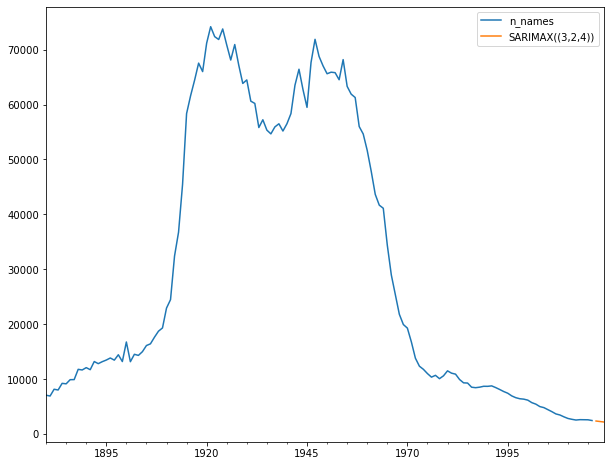

In [77]:
start = len(mary)
end = len(mary)+2
forecast = models_a.predict(start, end, typ='levels', dynamic=True).rename('SARIMAX((3,2,4))')
pd.concat([mary, forecast], axis=1).plot(figsize=(10, 8))
# test_mary.plot(legend=True, figsize=(10, 8))
# forecast.plot(legend=True)
# mary.plot(legend=True)

In [53]:
#mary will see the constant trend for next two years 

emma

In [175]:
train_emma = emma.iloc[:100]
test_emma = emma.iloc[100:]
start2 = len(train_emma)
end2 = len(emma)-1

In [178]:
#the series is not stationary so it is better to use SARIMAX to do forecast
models2 = SARIMAX(train_emma, order=(0,1,1), seasonal_order=(0,0,0,0), trace='c') .fit(disp=0)
# models2.summary()

<AxesSubplot:xlabel='year'>

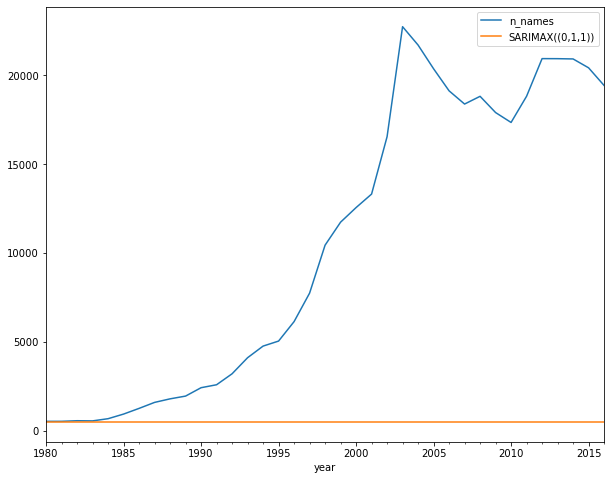

In [179]:
predictions2 = models2.predict(start2, end2, typ='levels').rename('SARIMAX((0,1,1))')

test_emma.plot(legend=True, figsize=(10, 8))
predictions2.plot(legend=True)
#prediction is not good

In [81]:
#the series is not stationary so it is better to use SARIMAX to do forecast
models2 = SARIMAX(emma, order=(0,1,1), seasonal_order=(0,0,0,0)) .fit(disp=0)
# models.summary()

In [82]:
print('RMSE:', {rmse(test_emma.n_names, predictions2)})
print('test_mean:', test_emma.n_names.mean())
print('pred_mean:', predictions2.mean())

#the error score show that the model could not predict well

RMSE: {12973.847960979538}
test_mean: 10512.756756756757
pred_mean: 493.18901100953576


<AxesSubplot:>

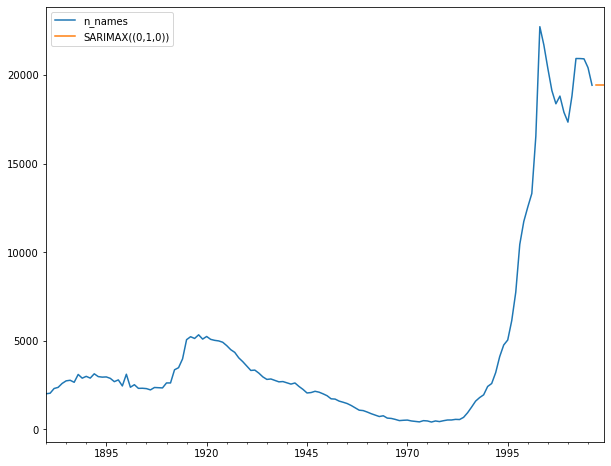

In [340]:
start2 = len(emma)
end2 = len(emma)+2
forecast2 = models2.predict(start2, end2, typ='levels', dynamic=True).rename('SARIMAX((0,1,0))')
pd.concat([emma, forecast2], axis=1).plot(figsize=(10, 8))

In [ ]:
#naming baby as emma seems to be constant for next two years

Anna

In [83]:
train_anna = anna.iloc[:-12]
test_anna = anna.iloc[-12:]
start3 = len(train_anna)
end3 = len(anna)-1

In [84]:
#the series is not stationary so it is better to use SARIMAX to do forecast
models3 = SARIMAX(train_emma, order=(2,0,1), seasonal_order=(0,0,0,0)) .fit(disp=0)
# models2.summary()

In [85]:
#the series is not stationary so it is better to use SARIMAX to do forecast
models3 = SARIMAX(train_anna, order=(2,0,1), seasonal_order=(0,0,0,0)) .fit(disp=0)
# models2.summary()

<AxesSubplot:xlabel='year'>

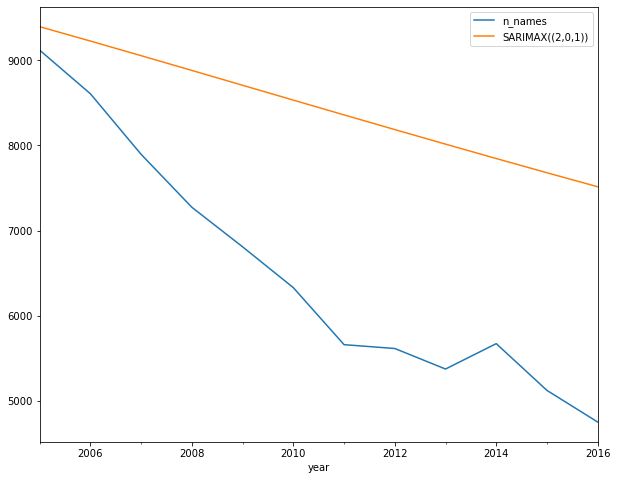

In [86]:
predictions3 = models3.predict(start3, end3, typ='levels').rename('SARIMAX((2,0,1))')

test_anna.plot(legend=True, figsize=(10, 8))
predictions3.plot(legend=True)

In [87]:
print('RMSE:', {rmse(test_anna.n_names, predictions3)})
print('test_mean:', test_anna.n_names.mean())
print('pred_mean:', predictions3.mean())
#not bad, the error and the mean value, both are in the same order which is not good

RMSE: {2092.1552008444937}
test_mean: 6520.166666666667
pred_mean: 8449.26047178825


In [88]:
#the series is not stationary so it is better to use SARIMAX to do forecast
models3 = SARIMAX(anna, order=(2,0,1), seasonal_order=(0,0,0,0)) .fit(disp=0)
# models3.summary()

<AxesSubplot:>

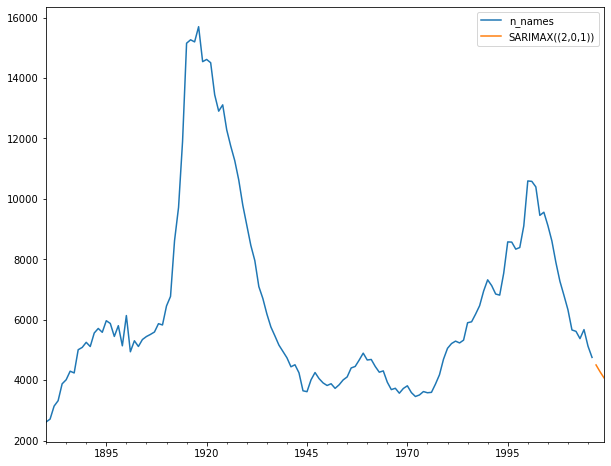

In [89]:
start3 = len(anna)
end3 = len(anna)+2
forecast3 = models3.predict(start3, end3, typ='levels', dynamic=True).rename('SARIMAX((2,0,1))')
pd.concat([anna, forecast3], axis=1).plot(figsize=(10, 8))

In [ ]:
#the forecast denotes downward trend for name of anna for coming 2 years!

## Exercise 2: 

Using ARIMA-based models and the `HospitalityEmployees.csv` file, forecast the number of *Hospitality Employees* **1** year into the future. Provide an interpretation of your findings

**Note:** Make sure to perform the necessary exploratory steps as well as to visualize your data & evaluate your results. 

In [101]:
# exercise 2
Data = pd.read_csv('../data/HospitalityEmployees.csv')
df = Data.copy()

In [102]:
df.head(5)

,Date,Employees
0,1/1/1990,1064.5
1,2/1/1990,1074.5
2,3/1/1990,1090.0
3,4/1/1990,1097.4
4,5/1/1990,1108.7


In [120]:
df.tail(5)

,Employees
Date,
2018-08-01,2019.1
2018-09-01,1992.5
2018-10-01,1984.3
2018-11-01,1990.1
2018-12-01,2000.2


In [103]:
df.Date = pd.to_datetime(df.Date)
df.Date.index.freq = 'MS'
df.set_index('Date', inplace=True)

<AxesSubplot:xlabel='Date'>

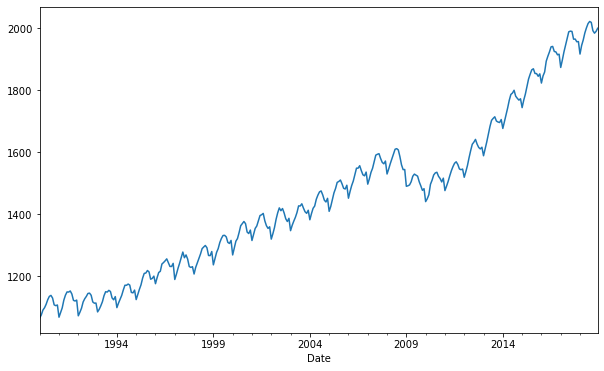

In [107]:
#plot the employee time series
df.Employees.plot(figsize=(10, 6))

In [109]:
#test to be stationary, however in the plot it is obvious it is not
print(adf_test(df.Employees))
print(kpss_test(df.Employees))

Results of Dickey-Fuller Test:


Test Statistic                   0.901284
p-value                          0.993107
#Lags Used                      17.000000
Number of Observations Used    330.000000
Critical Value (1%)             -3.450322
Critical Value (5%)             -2.870338
Critical Value (10%)            -2.571458
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has unit root and is non-stationary
None
Results of KPSS Test:


Test Statistic            2.811347
p-value                   0.010000
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has unit root and is non-stationary
None


In [ ]:
#the p value is high, the stationary series should be transform to stationary through differencing

In [112]:
df.Employees_diff = diff(df.Employees, k_diff=2)
print(adf_test(df.Employees_diff))
print(kpss_test(df.Employees_diff))

Results of Dickey-Fuller Test:


Test Statistic                  -5.139385
p-value                          0.000012
#Lags Used                      16.000000
Number of Observations Used    329.000000
Critical Value (1%)             -3.450384
Critical Value (5%)             -2.870365
Critical Value (10%)            -2.571472
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has no unit root & is stationary
None
Results of KPSS Test:


Test Statistic           0.016696
p-value                  0.100000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has no unit root & is stationary
None


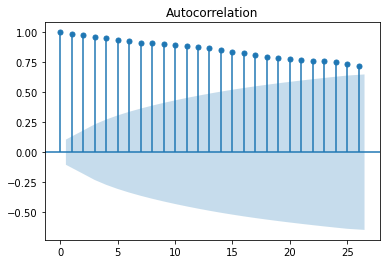

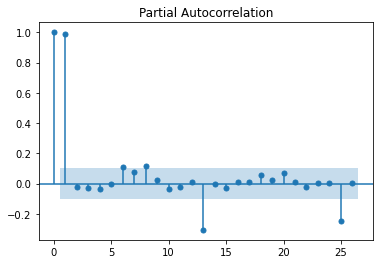

In [115]:
#to evaluate p, q, d:
plot_acf(df.Employees);
plot_pacf(df.Employees);

In [ ]:
#it seems p=1, q=2 and d =2, it could be approuve by auto arima, before, the seasonality frequance should be determined:

<AxesSubplot:xlabel='Date'>

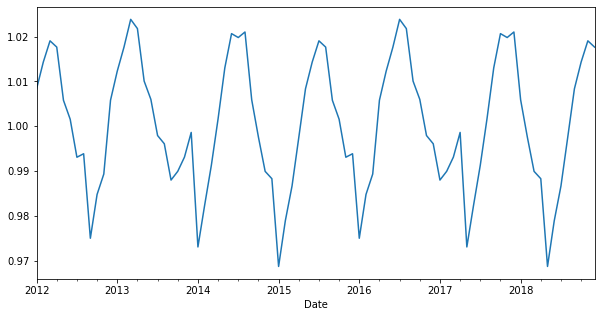

In [125]:
seasonal_decompose(df.Employees.loc['2012':'2018'], model='mul', freq=40).seasonal.plot(figsize=(10, 5))

In [ ]:
#denoting almost each 12 months there is seasonality

In [126]:
auto_arima(df.Employees, trace='True', m=12, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2213.793, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2974.636, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2707.381, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2980.790, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2340.936, Time=0.61 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2327.590, Time=1.70 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=2.23 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2264.870, Time=1.64 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=2.91 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=2227.508, Time=0.62 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=2220.1

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [131]:
df.shape

(348, 1)

In [151]:
train = df.Employees.iloc[:336]
test = df.Employees.iloc[336:]
start = len(train)
end = len(df)-1

In [160]:
#there is sesonality and it is not stationary series, 
#it had better use the SARIMAX: I don't know why with SARIMAX the error will be high???
# model = SARIMAX(train, order=((1, 1, 2)), seasonality_order=(1, 0, 1, 12), trace = 'c').fit(disp=0)
model = ARIMA(train.astype(float), order=((1, 1, 2))).fit(disp=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Employees   No. Observations:                  335
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1422.351
Method:                       css-mle   S.D. of innovations             16.886
Date:                Wed, 27 Jul 2022   AIC                           2854.702
Time:                        09:46:17   BIC                           2873.773
Sample:                    02-01-1990   HQIC                          2862.305
                         - 12-01-2017                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.6864      1.504      1.787      0.074      -0.261       5.634
ar.L1.D.Employees     0.4582      0.090      5.089      0.000       0.282       0.635
ma.L1.D.Employees    -0.4247      0.109     -3.895      0.000      -0.638      -0.211
ma.L2.D.Employees     0.3107      0.094      3.288      0.001       0.125       0.496
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1826           +0.0000j            2.1826            0.0000
MA.1            0.6836           -1.6588j            1.7941           -0.1878
MA.2            0.6836           +1.6588j            1.7941            0.1878
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='Date'>

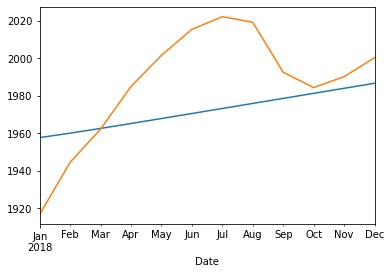

In [161]:
predictions =  model.predict(start, end, typ='levels', dynamic = True)
predictions.plot()
test.plot()

In [162]:
print('RMSE:', {rmse(test, predictions)})
print('test_mean:', test.mean())
print('pred_mean:', predictions.mean())
#not bad, the error and the mean value have different order and also predictions' mean and test'mean are almost as same value as  

RMSE: {29.05503107598497}
test_mean: 1986.125
pred_mean: 1971.9296458775818


In [167]:
#now we can extend the modeling to all data not just train and test to do forecasting for next 12 month

model = SARIMAX(df, order=(1,1,2), seasonal_order=(1,0,1,12)).fit(disp=0)

#model.summary()
#the frequescy is 12month that's why th 11 has been chosen
forecast = model.predict(start=len(df), end=len(df)+11, typ='levels').rename('SARIMA Forecast')

<AxesSubplot:xlabel='Date'>

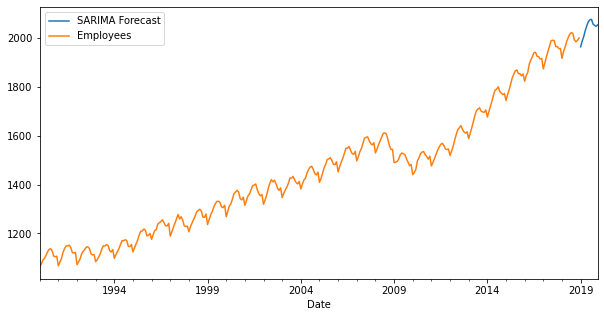

In [172]:
forecast.plot(figsize=(10, 5),legend=True)
df.Employees.plot(legend=True)